In [1]:
import numpy as np
import matplotlib.pyplot as plt 
import pandas as pd 
import seaborn as sns
import arviz as az
from statsmodels.tsa import stattools
import statsmodels.api as sm
import pymc3 as pm
import pymc

import sys
sys.path.insert(0, '..')
from utils.plot_lib import set_default

set_default(figsize=(6, 4))

### Bayesian EM for Mixture of Bivariate Normals

We're going to work with bivariates, so that's where the P-parameter controls is that we are bivariate normals. Again, we're going to work with three components in the mixture and we are going to have the same epsilon parameter that controls when to stop the algorithm. 

In [2]:
### Example of an EM algorithm for fitting a location mixture of 2 Gaussian components
### The algorithm is tested using simulated data

from scipy.stats import norm
from scipy.stats import multivariate_normal

## Clear the environment and load required libraries
np.random.seed(1)

## Generate data from a mixture with 2 components
p          = 2 # Bivariate normals
KK         = 3 # Number of componentes
w_true     = np.array([0.5, 0.3, 0.2])  # True weights associated with the components

mu_true    = np.zeros((KK, p)) # Matriz of true means
mu_true[0] = [0, 0] # True mean for the first component
mu_true[1] = [5, 5] # True mean for the second component
mu_true[2] = [-3, 7] # True mean for the third component

sigma_true = np.zeros((KK, p, p))   # Matriz of true covariance matrices
sigma_true[0] = np.array([[1, 0], [0, 1]])   # Covariance matrix of first component
sigma_true[1] = np.array([[2, 0.9], [0.9, 1]])   # Covariance matrix of second component
sigma_true[2] = np.array([[1, -0.9], [-0.9, 4]])   # Covariance matrix of third component

n          = 120         # Number of observations to be generated

### Step 1 ### Sample component indicators
cc_true    = np.random.choice([0, 1, 2], n, p = w_true) # C_i sample 
x     = []
### Step 2 ### Sample from normal distribution
for i in range(n):
  x.append(multivariate_normal.rvs(mean = mu_true[cc_true[i]], cov = sigma_true[cc_true[i]], size = 1))

x = np.array(x)
print('The first five samples of C_i are: {}'.format(cc_true[:5]))
print('The first five samples of the mixture are: \n{}'.format(x[:5]))

The first five samples of C_i are: [0 1 0 0 0]
The first five samples of the mixture are: 
[[ 0.12182127  1.12948391]
 [ 3.29215478  4.14244718]
 [-0.37528495 -0.63873041]
 [ 0.42349435  0.07734007]
 [-0.34385368  0.04359686]]


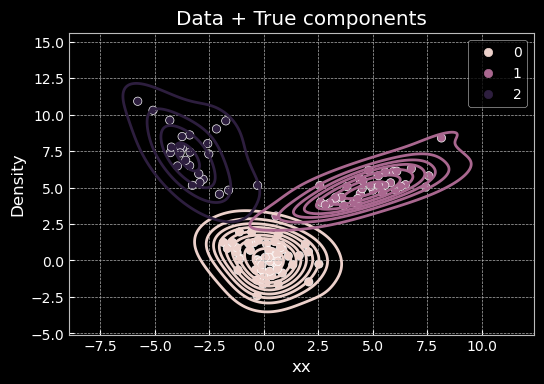

In [3]:
### Plotting the true distributions

# Plot f(x) along with the observations just sampled
sns.kdeplot(x[:, 0], x[:, 1], bw_method = .9, hue = cc_true, fill = False)
sns.scatterplot(x[:, 0], x[:, 1], hue = cc_true)
plt.xlabel('xx')
plt.ylabel('Density')
plt.title('Data + True components')
plt.legend()
plt.show()

### Initial guess of data

The initial guess for w are: 
[0.33333333 0.33333333 0.33333333]
The initial guess for mu are: 
[[ 4.54873655  3.65964081]
 [ 3.66839328  5.70280922]
 [ 1.70491136 -0.07722635]]
The initial guess for sigma are: 
[[[ 3.34787295 -0.09543668]
  [-0.09543668  3.56539587]]

 [[ 3.34787295 -0.09543668]
  [-0.09543668  3.56539587]]

 [[ 3.34787295 -0.09543668]
  [-0.09543668  3.56539587]]]


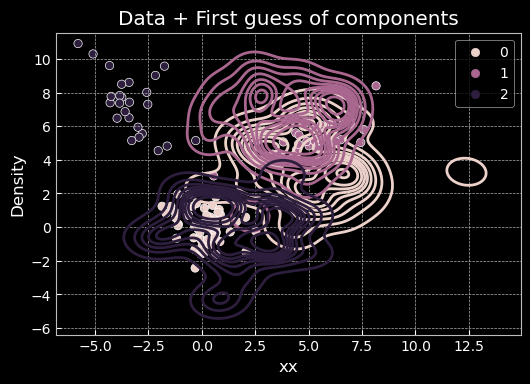

In [4]:
## Initialize the parameters and initial guess
w     = np.ones(KK) / KK                         # Assign equal weight to each component to start with
mu    = multivariate_normal.rvs(mean = np.mean(x, axis = 0), cov = np.cov(x.T), size = KK)   # Random cluster centers randomly spread over the support of the data
Sigma = np.zeros((KK, p, p))  # Initial covariance mat deviation
Sigma[0] = np.cov(x.T) / KK   # Covariance matrix of first component
Sigma[1] = np.cov(x.T) / KK   # Covariance matrix of second component
Sigma[2] = np.cov(x.T) / KK   # Covariance matrix of third component

print('The initial guess for w are: \n{}'.format(w))
print('The initial guess for mu are: \n{}'.format(mu))
print('The initial guess for sigma are: \n{}'.format(Sigma))

# Sampling to visualize first guess
### Step 1 ### Sample component indicators
cc_test    = np.random.choice([0, 1, 2], n, p = w) # C_i sample 
xx     = []
### Step 2 ### Sample from normal distribution
for i in range(n):
  xx.append(multivariate_normal.rvs(mean = mu[cc_test[i]], cov = Sigma[cc_test[i]], size = 1))

xx = np.array(xx)

# Plotting first guess
sns.kdeplot(xx[:, 0], xx[:, 1], bw_method = .4, hue = cc_test, fill = False)
sns.scatterplot(x[:, 0], x[:, 1], hue = cc_true)
plt.xlabel('xx')
plt.ylabel('Density')
plt.title('Data + First guess of components')
plt.legend()
plt.show()

### Initializing priors

In [5]:
## The actual MCMC algorithm starts here
# Priors
aa  = np.ones(KK)           # Uniform prior on w (Beta prior for w)
dd  = np.mean(x, axis = 0)  # Mean of the mus (Bivariate prior for means)
DD  = 10 * np.cov(x.T)      # Covariance matrix for means (Bivariate prior for means)
nu  = p                     # Inverse Wishard prior for covariance
SS = np.cov(x.T) / 3        # Scale matrix for (Wishard prior for covariance)

Current iteration is: 0
Current iteration is: 25
Current iteration is: 50
Current iteration is: 75


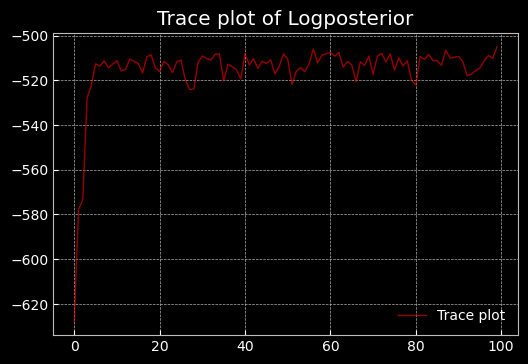

In [6]:
from scipy.stats import dirichlet
from scipy.stats import invwishart

# Number of iterations of the sampler
rrr   = 100   # Number of iterations

# Storing the samples
cc_out    = np.zeros((rrr, n))        # Store outputs
w_out     = np.zeros((rrr, KK))       # Sample of the weights
mu_out    = np.zeros((rrr, KK, p))    # Sample of mus
sigma_out = np.zeros((rrr, KK, p, p)) # Sample of sigmas
logpost   = np.zeros(rrr)             # Used to monitor convergence

for s in range(rrr):
  cc = np.zeros(n)
  # Sample the indicators
  for i in range(n):
    v = np.zeros(KK)
    for k in range(KK):
      v[k] = np.log(w[k]) + multivariate_normal.logpdf(mean = mu[k, :], cov = Sigma[k, :, :], x = x[i, :]) # Compute the log of the weights
    v     = np.exp(v - max(v)) / np.sum(np.exp(v - max(v)))  # Go from logs to actual weights in a numerically stable manner
    cc[i] = np.random.choice([0, 1, 2], 1, p = v) # C_i sample 

  # Sample the weights
  unique, counts = np.unique(cc[:], return_counts=True)
  w = dirichlet.rvs(alpha = aa + counts, size = 1)[0]

  # Sample the means
  DD_st = np.zeros((p, p))
  for k in range(KK):
    mk = np.sum(cc[:] == k)
    xsumk = np.sum(x[cc[:] == k], axis = 0)
    DD_st = np.linalg.inv(mk *  np.linalg.inv(Sigma[k, :, :]) + np.linalg.inv(DD))
    dd_st = np.dot(DD_st, (np.dot(np.linalg.inv(Sigma[k, :, :]), xsumk[:, np.newaxis]) +  np.dot(np.linalg.inv(DD), dd[:, np.newaxis]))).ravel()
    mu[k, :] = multivariate_normal.rvs(mean = dd_st, cov = DD_st, size = 1)

  # Sample the variances
  xcensumk = np.zeros((KK,p,p))
  for i in range(n):
    xcensumk[int(cc[i]), :, :] = xcensumk[int(cc[i]), :, :] + np.dot((x[i, :] - mu[int(cc[i]), :])[:, np.newaxis], (x[i, :] - mu[int(cc[i]), :])[:, np.newaxis].T)
  for k in range(KK):
    Sigma[k, :, :] = invwishart.rvs(df = nu + np.sum(cc[:] == k), scale = SS + xcensumk[k, :, :], size = 1)

  # Store samples
  cc_out[s, :]   = cc
  w_out[s, :]       = w
  mu_out[s, :, :]   = mu
  sigma_out[s, :, :, :]   = Sigma

  for i in range(n):
    # Computing logposterior likelihood term
    logpost[s] = logpost[s] + np.log(w[int(cc[i])]) + multivariate_normal.logpdf(mean = mu[int(cc[i]), :], cov = Sigma[int(cc[i]), :, :], x = x[i, :])
  # W term
  logpost[s] = logpost[s] + dirichlet.logpdf(alpha = aa, x = w)
  # Mu and Sigmaterm
  for k in range(KK):
    logpost[s] = logpost[s] + multivariate_normal.logpdf(mean = dd, cov = DD, x = mu[k, :]) # Mu
    logpost[s] = logpost[s] + invwishart.logpdf(df = nu, scale = SS, x = Sigma[k, :, :]) # Sigma

  if s / 25 == np.floor(s / 25):
    print('Current iteration is: {}'.format(s))

## Plot the logposterior distribution for various samples
fig, ax = plt.subplots(1, 1)
ax.plot(np.arange(len(logpost)), logpost, 'r-', lw=1, alpha=0.6, label='Trace plot') # Trace plot of data
ax.legend(loc='best', frameon=False)
# plot density estimate of the posterior
plt.title('Trace plot of Logposterior')
plt.show()

In [7]:
print('The final Mu_hat values are: {}'.format(mu))
print('The true mu values are: {}\n'.format(mu_true))

print('The final sigma_hat values are: {}'.format(Sigma))
print('The true sigma values are: {}\n'.format(sigma_true))

print('The final w_hat values are: {}'.format(w))
print('The true w values are: {}\n'.format(w_true))

print('The final c_hat values are: {}'.format(cc[:10]))
print('The true c values are: {}\n'.format(cc_true[:10]))

The final Mu_hat values are: [[ 4.81195098  4.92396115]
 [-3.15325373  7.22298179]
 [ 0.10426421  0.16925444]]
The true mu values are: [[ 0.  0.]
 [ 5.  5.]
 [-3.  7.]]

The final sigma_hat values are: [[[ 2.04945842  0.68783483]
  [ 0.68783483  0.6440272 ]]

 [[ 1.16061513 -1.00687081]
  [-1.00687081  2.82023446]]

 [[ 0.83251855 -0.15679831]
  [-0.15679831  0.92821884]]]
The true sigma values are: [[[ 1.   0. ]
  [ 0.   1. ]]

 [[ 2.   0.9]
  [ 0.9  1. ]]

 [[ 1.  -0.9]
  [-0.9  4. ]]]

The final w_hat values are: [0.33547732 0.19292381 0.47159887]
The true w values are: [0.5 0.3 0.2]

The final c_hat values are: [2. 0. 2. 2. 2. 2. 2. 2. 2. 0.]
The true c values are: [0 1 0 0 0 0 0 0 0 1]



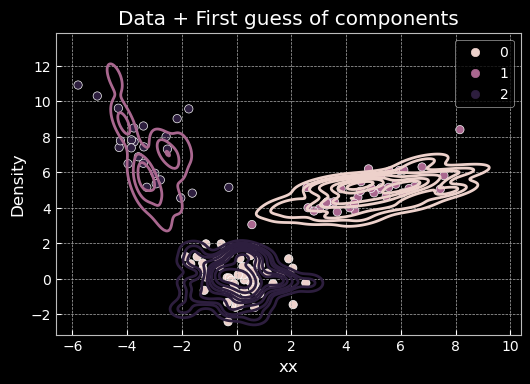

In [8]:
# Sampling to visualize first guess
### Step 1 ### Sample component indicators
cc_final    = np.random.choice([0, 1, 2], n, p = w) # C_i sample 
xx     = []
### Step 2 ### Sample from normal distribution
for i in range(n):
  xx.append(multivariate_normal.rvs(mean = mu[cc_final[i]], cov = Sigma[cc_final[i]], size = 1))

xx = np.array(xx)

# Plotting first guess
sns.kdeplot(xx[:, 0], xx[:, 1], bw_method = .4, hue = cc_final, fill = False)
sns.scatterplot(x[:, 0], x[:, 1], hue = cc_true)
plt.xlabel('xx')
plt.ylabel('Density')
plt.title('Data + First guess of components')
plt.legend()
plt.show()